In [1]:
import torch
import torch.nn as nn
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, ToPILImage
import torch.nn.functional as F

import time
import copy
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
import os
# os.environ['http_proxy'] = "" 
# os.environ['https_proxy'] = ""
device_id = 0
torch.cuda.set_device('cuda:%d' % device_id)

In [3]:
from diffusers.pipelines.stable_diffusion import StableDiffusionPipeline
from piecewise_rectified_flow.src.scheduler_perflow import PeRFlowScheduler

pipe = StableDiffusionPipeline.from_pretrained("/root/wuyujia_proj/RectifID/models/perflow-sd15-dreamshaper", safety_checker=None, torch_dtype=torch.float16, local_files_only=True)
# pipe = StableDiffusionPipeline.from_pretrained("hansyan/perflow-sd15-realisticVisionV51", safety_checker=None, torch_dtype=torch.float16)
# pipe = StableDiffusionPipeline.from_pretrained("hansyan/perflow-sd15-disney", safety_checker=None, torch_dtype=torch.float16)
pipe.scheduler = PeRFlowScheduler.from_config(pipe.scheduler.config, prediction_type="diff_eps", num_time_windows=4)

# Our method also supports SD 2.1 (not used in the paper)
# pipe = StableDiffusionPipeline.from_pretrained("hansyan/perflow-sd21-artius", safety_checker=None, torch_dtype=torch.bfloat16)
# pipe.scheduler = PeRFlowScheduler.from_config(pipe.scheduler.config, prediction_type="velocity", num_time_windows=4)

/root/anaconda3/envs/perflow/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-21 15:48:19.829248: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-21 15:48:19.885666: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 15:48:19.885702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 15:48:19.887205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cu

In [4]:
for module in [pipe.vae, pipe.text_encoder, pipe.unet]:
    for param in module.parameters():
        param.requires_grad = False

pipe.to("cuda")
pipe.set_progress_bar_config(disable=True)

my_forward = pipe.__call__.__wrapped__

In [5]:
import insightface
from onnx2torch import convert

# antelopev2
# https://github.com/deepinsight/insightface/tree/master/python-package#model-zoo
detector = insightface.model_zoo.get_model('/root/wuyujia_proj/RectifID/models/antelopev2/scrfd_10g_bnkps.onnx', provider_options=[{'device_id': device_id}, {}])
detector.prepare(ctx_id=0, input_size=(640, 640))
model = convert('/root/wuyujia_proj/RectifID/models/antelopev2/glintr100.onnx').eval().to('cuda')
for param in model.parameters():
    param.requires_grad_(False)

2024-10-21 15:48:27.813264042 [E:onnxruntime:Default, provider_bridge_ort.cc:1992 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1637 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.12: cannot open shared object file: No such file or directory

2024-10-21 15:48:27.813291091 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:965 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Require cuDNN 9.* and CUDA 12.*. Please install all dependencies as mentioned in the GPU requirements page (https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements), make sure they're in the PATH, and that your GPU is supported.


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


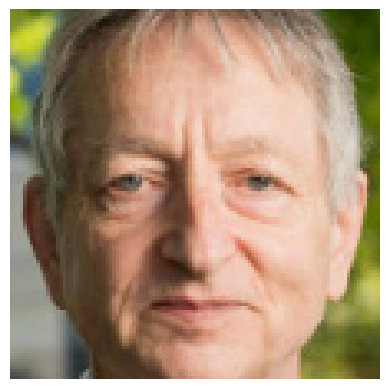

In [6]:
from PIL import Image
import torchvision.transforms.functional as TF
import kornia

ref = 'assets/hinton.jpg'
# ref = 'assets/bengio.jpg'
# ref = 'assets/schmidhuber.jpg'
# ref = 'assets/johansson.jpg'
# ref = 'assets/newton.jpg'

ref_image = Image.open(ref).convert("RGB")

with torch.no_grad():
    det_thresh_backup = detector.det_thresh
    boxes = []
    while len(boxes) == 0:
        boxes, kpss = detector.detect(np.array(ref_image), max_num=1)
        detector.det_thresh -= 0.1
    detector.det_thresh = det_thresh_backup
    M = insightface.utils.face_align.estimate_norm(kpss[0])
    ref_image_cropped = kornia.geometry.transform.warp_affine(
        TF.to_tensor(ref_image).unsqueeze(0).to('cuda'), torch.tensor(M).float().unsqueeze(0).to('cuda'), (112, 112)
    ) * 2 - 1

    ref_embedding = model(ref_image_cropped)

cropped_image = np.array((ref_image_cropped[0] / 2 + 0.5).cpu().permute(1, 2, 0) * 255, dtype=np.uint8)
plt.imshow(cropped_image)
plt.axis("off")
plt.show()

In [8]:
import tensorflow as tf
from deepface import DeepFace

tf.config.set_visible_devices([], device_type='GPU')
attribute = DeepFace.analyze(img_path=ref, actions = ['gender', 'race'])

Action: gender:   0%|          | 0/2 [00:00<?, ?it/s] 

Action: race: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]  


In [9]:
idx = np.argmax([a['region']['w'] * a['region']['h'] for a in attribute])
print(attribute[idx]['dominant_gender'], attribute[idx]['dominant_race'])

Man white


In [10]:
from diffusers.utils.torch_utils import randn_tensor

generator = torch.manual_seed(42)

latents = nn.Parameter(randn_tensor((4, 4, 64, 64), generator=generator, device=pipe._execution_device, dtype=pipe.text_encoder.dtype))
latents0 = latents.data[:1].clone()
optimizer = torch.optim.SGD([latents], 1)  # 1 or 2

In [11]:
prompt = 'Selfie of a middle-aged person on a yacht'
# prompt = 'A photo of a person wearing a suit, holding red roses in hand, upper body, behind is the Eiffel Tower'
# prompt = 'a man sitting in the cafe, comic, graphic illustration, comic art, graphic novel art, vibrant, highly detailed, colored, 2d minimalistic'

# prompt = 'a photo of a person'
# prompt = 'a person with a sad expression'
# prompt = 'a person with a happy expression'
# prompt = 'a person with a puzzled expression'
# prompt = 'a person with an angry expression'
# prompt = 'a person plays the LEGO toys'
# prompt = 'a person on the beach'
# prompt = 'a person piloting a fighter jet'
# prompt = 'a person wearing the sweater, a backpack and camping stove, outdoors, RAW, ultra high res'
# prompt = 'a person wearing a scifi spacesuit in space'
# prompt = 'cubism painting of a person'
# prompt = 'fauvism painting of a person'
# prompt = 'cave mural depicting a person'
# prompt = 'pointillism painting of a person'
# prompt = 'a person latte art'

if attribute[idx]['dominant_gender'] == 'Man':
    prompt = prompt.replace('person', attribute[idx]['dominant_race'] + ' man')
else:
    prompt = prompt.replace('person', attribute[idx]['dominant_race'] + ' woman')
# prompt = prompt + ', face'

  0%|          | 0/51 [00:00<?, ?it/s]

loss: 97.04065704345703
grad: [162.125, 75.375, 13.4296875, 9.890625]
time: 0.45328426361083984 0.08793425559997559 (0.500000) 0.036034584045410156 0.9545779228210449 0.0013270378112792969


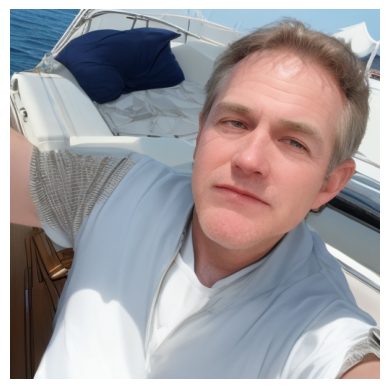

 20%|█▉        | 10/51 [00:13<00:55,  1.35s/it]

loss: 39.85162353515625
grad: [15.75, 11.4765625, 5.55859375, 4.7421875]
time: 0.3468325138092041 0.11788821220397949 (0.500000) 0.021003007888793945 0.8496353626251221 0.0017096996307373047


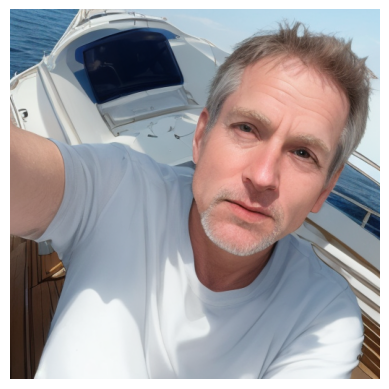

 39%|███▉      | 20/51 [00:27<00:42,  1.36s/it]

loss: 13.415837287902832
grad: [11.109375, 7.60546875, 3.259765625, 2.935546875]
time: 0.3502194881439209 0.12392115592956543 (0.500000) 0.02500295639038086 0.8626716136932373 0.0009870529174804688


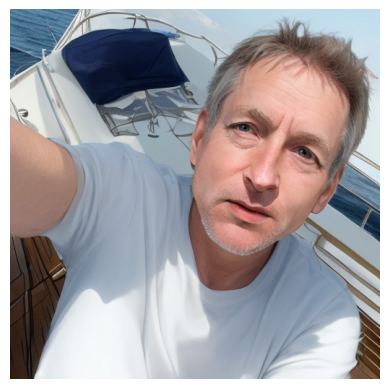

 59%|█████▉    | 30/51 [00:41<00:28,  1.36s/it]

loss: 5.660045146942139
grad: [8.65625, 4.421875, 2.41796875, 2.287109375]
time: 0.357128381729126 0.12203502655029297 (0.500000) 0.02132582664489746 0.8583886623382568 0.0021347999572753906


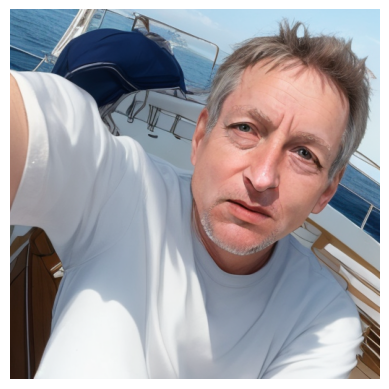

 78%|███████▊  | 40/51 [00:54<00:14,  1.36s/it]

loss: 3.342103958129883
grad: [5.83984375, 2.705078125, 1.95703125, 1.89453125]
time: 0.35558366775512695 0.11716818809509277 (0.500000) 0.020731449127197266 0.8606574535369873 0.0008523464202880859


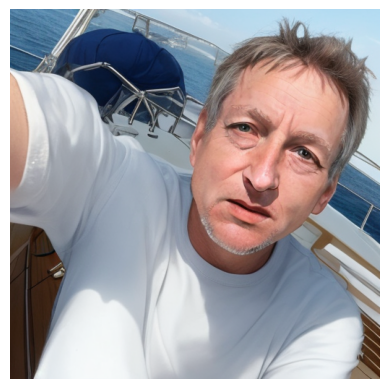

 98%|█████████▊| 50/51 [01:08<00:01,  1.37s/it]

loss: 3.1151294708251953
grad: [4.0234375, 2.099609375, 1.5126953125, 1.623046875]
time: 0.3577091693878174 0.11758708953857422 (0.500000) 0.022020339965820312 0.8637545108795166 0.0017352104187011719


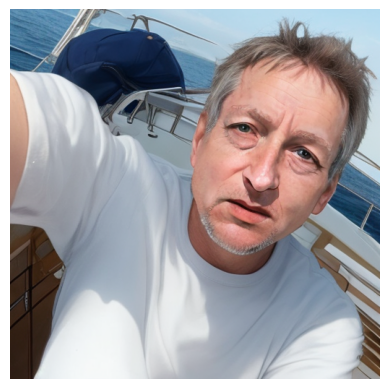

100%|██████████| 51/51 [01:10<00:00,  1.38s/it]


In [12]:
latents_last = latents.data.clone()
latents_last_e = latents.data.clone()
initialized_i = -1

def callback(self, i, t, callback_kwargs):
    global latents_last, latents_last_e, initialized_i
    if initialized_i < i:
        latents[i:(i+1)].data.copy_(callback_kwargs['latents'])
        latents_last[i:(i+1)].copy_(callback_kwargs['latents'])
        latents_last_e[i:(i+1)].copy_(callback_kwargs['latents'])
        initialized_i = i
    if i < 3:
        callback_kwargs['latents'] += latents[(i+1):(i+2)] - latents[(i+1):(i+2)].detach()
    latents_e = callback_kwargs['latents'].data.clone()
    callback_kwargs['latents'] += latents_last[i:(i+1)].detach() - callback_kwargs['latents'].detach()
    callback_kwargs['latents'] += latents_e.detach() - latents_last_e[i:(i+1)].detach()
    # callback_kwargs['latents'] += latents[i:(i+1)].detach() - latents_last_e[i:(i+1)].detach()
    callback_kwargs['latents'] += (latents[i:(i+1)].detach() - latents_last_e[i:(i+1)].detach()) * 0.95796674
    latents_last[i:(i+1)].copy_(callback_kwargs['latents'])
    latents_last_e[i:(i+1)].data.copy_(latents_e)
    latents[i:(i+1)].data.copy_(latents_e)
    return callback_kwargs

for epoch in tqdm(range(51)):
    t0 = time.time()
    image = my_forward(pipe, prompt=prompt, num_inference_steps=4, guidance_scale=3.0, latents=latents0+latents[:1]-latents[:1].detach(), output_type='pt', return_dict=False, callback_on_step_end=callback)[0][0]
    t1 = time.time()
    
    det_thresh_backup = detector.det_thresh
    boxes = []
    while len(boxes) == 0:
        boxes, kpss = detector.detect(np.array(image.permute(1, 2, 0).detach().cpu().numpy() * 255, dtype=np.uint8), max_num=1)
        detector.det_thresh -= 0.1
    det_thresh_backup2 = detector.det_thresh + 0.1
    detector.det_thresh = det_thresh_backup

    t2 = time.time()
    M = insightface.utils.face_align.estimate_norm(kpss[0])
    image_cropped = kornia.geometry.transform.warp_affine(
        image.float().unsqueeze(0), torch.tensor(M).float().unsqueeze(0).to('cuda'), (112, 112)
    ) * 2 - 1
    embedding = model(image_cropped)
    loss = (1 - F.cosine_similarity(embedding, ref_embedding)) * 100
    t3 = time.time()

    optimizer.zero_grad()
    loss.backward()
    t4 = time.time()
    grad_norm = latents.grad.reshape(4, -1).norm(dim=-1)
    latents.grad /= grad_norm.reshape(4, 1, 1, 1).clamp(min=1)
    # latents.grad.clamp_(min=-2e-2, max=2e-2)  # optional for removing artifacts
    optimizer.step()
    t5 = time.time()

    if epoch % 10 == 0:
        print('loss:', loss.data.item())
        print('grad:', grad_norm.tolist())
        print('time:', t1-t0, t2-t1, '(%f)' % det_thresh_backup2, t3-t2, t4-t3, t5-t4)
        plt.imshow(np.array(image.permute(1, 2, 0).detach().cpu() * 255, dtype=np.uint8))
        plt.axis("off")
        plt.show()
    del image